<a href="https://colab.research.google.com/github/dijashahzad746/deep-learning/blob/main/CNN(skin_lesion_classification_before_resampling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from imblearn.combine import SMOTEENN
import time

In [2]:
from google.colab import files
uploaded=files.upload()

Saving hmnist_28_28_RGB.csv to hmnist_28_28_RGB.csv


In [3]:
data = pd.read_csv('/content/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [4]:
X = data.iloc[:,:2352]
y = data.iloc[:,-1]

In [5]:
y.value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [6]:
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} sampel")

Class 0: 327 sampel
Class 1: 514 sampel
Class 2: 1099 sampel
Class 3: 115 sampel
Class 4: 6705 sampel
Class 5: 142 sampel
Class 6: 1113 sampel


In [7]:
class_labels=["akiec","bcc","bkl","df","mel","nv","vasc"]

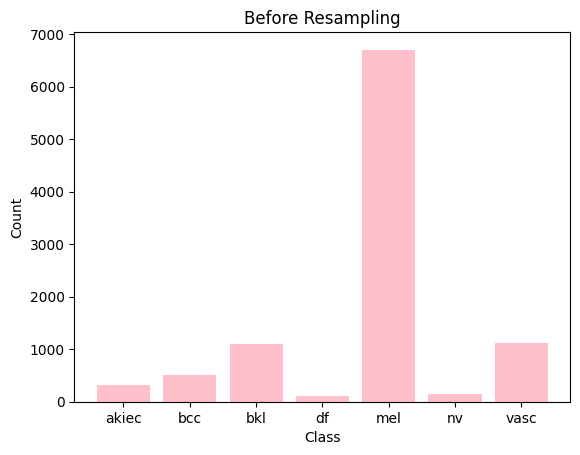

In [8]:
# Plot the bar graph
class_counts = y.value_counts().sort_index()
plt.bar(class_labels, class_counts.values, color='pink')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Before Resampling')

# Show the plot
plt.show()

In [30]:
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.25 , random_state = 42)
X_train = np.array(X_train).reshape(-1, 28, 28, 3)
X_test = np.array(X_test).reshape(-1, 28, 28, 3)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [31]:
model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(7, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_8 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                      

In [16]:
# Callback to save the best model
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Minimization mode for validation loss
    verbose=1  # Display messages when saving the model
)

# Callback to reduce learning rate when validation loss stagnates
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Learning rate reduction factor (0.2 = 20%)
    patience=3,
    min_lr=0.0001,  # Lower bound for learning rate
    verbose=1  # Display messages when reducing learning rate
)

# Callback to stop training if validation loss doesn't improve for several epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs without improvement before stopping training
    verbose=1,  # Display messages when stopping training
    restore_best_weights=True  # Restore the best weights when stopping training
)

In [32]:
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

end_time = time.time()
training_time = (end_time - start_time)/60
print(f"Total training time: {training_time} minutes")

Epoch 1/25
235/235 [==============================] - ETA: 0s - loss: 1.2598 - accuracy: 0.6144
Epoch 1: val_loss did not improve from 0.02945
235/235 [==============================] - 55s 207ms/step - loss: 1.2598 - accuracy: 0.6144 - val_loss: 1.0047 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/25
235/235 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7106
Epoch 2: val_loss did not improve from 0.02945
235/235 [==============================] - 47s 202ms/step - loss: 0.8296 - accuracy: 0.7106 - val_loss: 1.3986 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 3/25
235/235 [==============================] - ETA: 0s - loss: 0.7570 - accuracy: 0.7264
Epoch 3: val_loss did not improve from 0.02945
235/235 [==============================] - 49s 209ms/step - loss: 0.7570 - accuracy: 0.7264 - val_loss: 1.1626 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 4/25
235/235 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.7368
Epoch 4: val_loss did not improve 

In [33]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

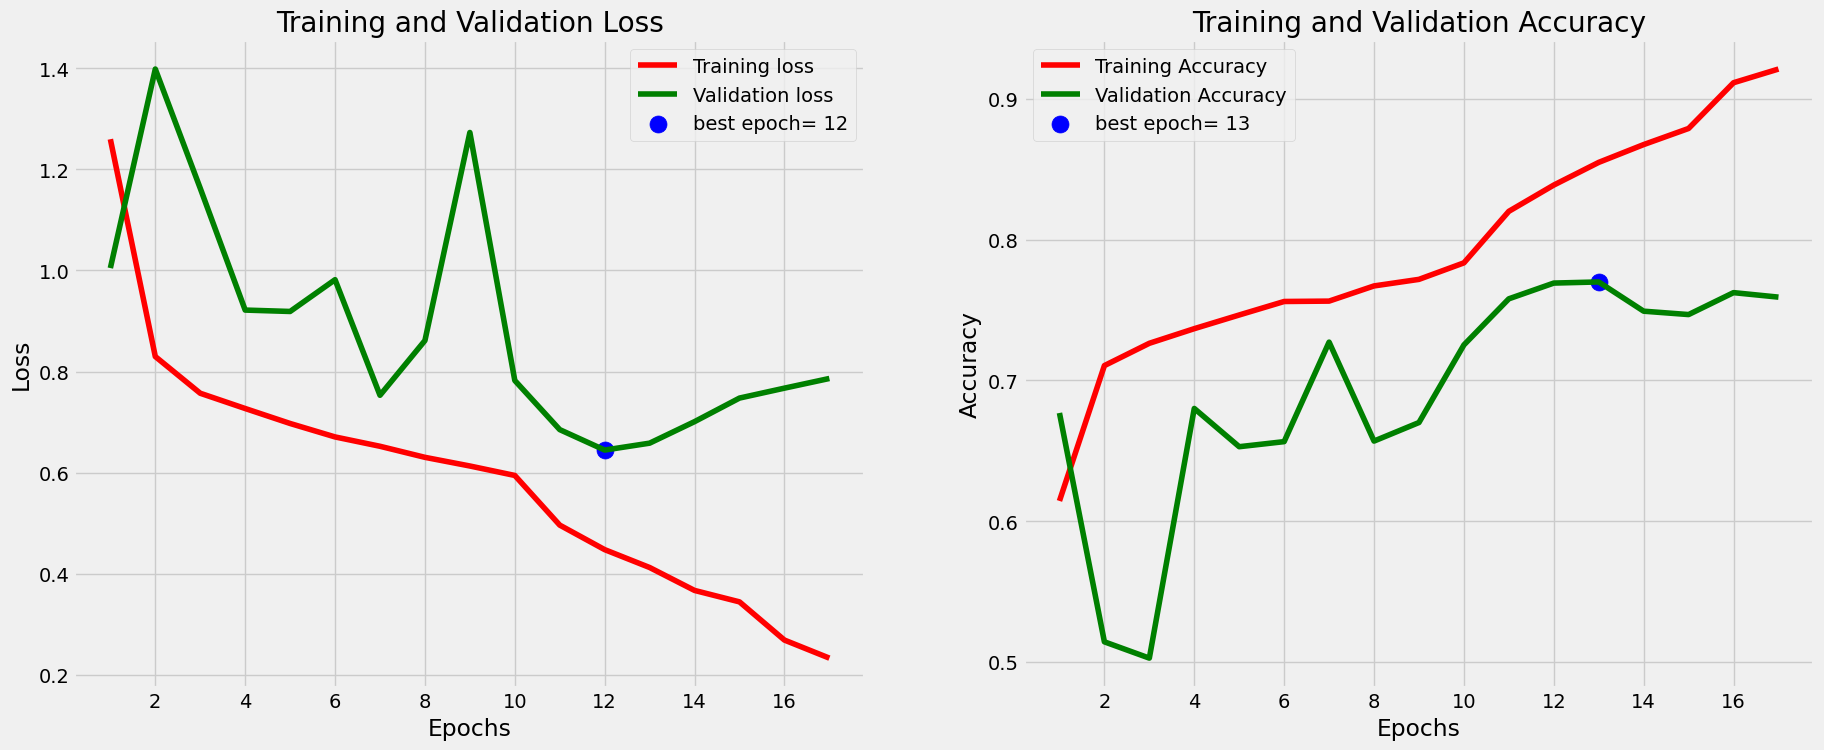

In [34]:
plot_training(history)

In [35]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

79/79 [==============================] - 5s 62ms/step - loss: 0.6446 - accuracy: 0.7692
Train Loss:  0.3913150131702423
Train Accuracy:  0.8618026971817017
--------------------
Test Loss:  0.6445633172988892
Test Accuracy:  0.7691693305969238


In [40]:
y_pred = model.predict(X_test)

79/79 [==============================] - 4s 54ms/step


In [41]:
y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_test , axis=1)

In [42]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [44]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7691693290734825
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.50      0.44        86
           1       0.61      0.60      0.60       114
           2       0.57      0.44      0.50       285
           3       0.71      0.16      0.26        32
           4       0.85      0.94      0.89      1668
           5       0.73      0.81      0.77        27
           6       0.56      0.34      0.42       292

    accuracy                           0.77      2504
   macro avg       0.63      0.54      0.55      2504
weighted avg       0.75      0.77      0.75      2504



In [45]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

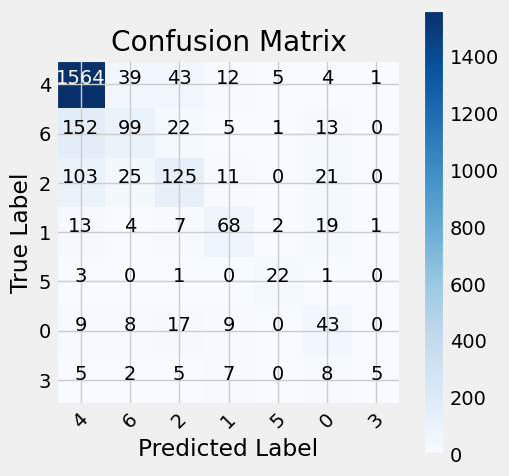

In [48]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [49]:
# y_test_unique_classes, y_test_class_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
num = 0
for cls, count in zip(classes_labels, [864, 1699, 1629, 1686, 1625, 1754, 1612]):
    print(f"Class {cls}: {cm[num,num]} from {count} sampel, incorrect prediction: {count-cm[num,num]}")
    num += 1

Class 4: 1564 from 864 sampel, incorrect prediction: -700
Class 6: 99 from 1699 sampel, incorrect prediction: 1600
Class 2: 125 from 1629 sampel, incorrect prediction: 1504
Class 1: 68 from 1686 sampel, incorrect prediction: 1618
Class 5: 22 from 1625 sampel, incorrect prediction: 1603
Class 0: 43 from 1754 sampel, incorrect prediction: 1711
Class 3: 5 from 1612 sampel, incorrect prediction: 1607
